In [4]:
!pip install numpy
!pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt

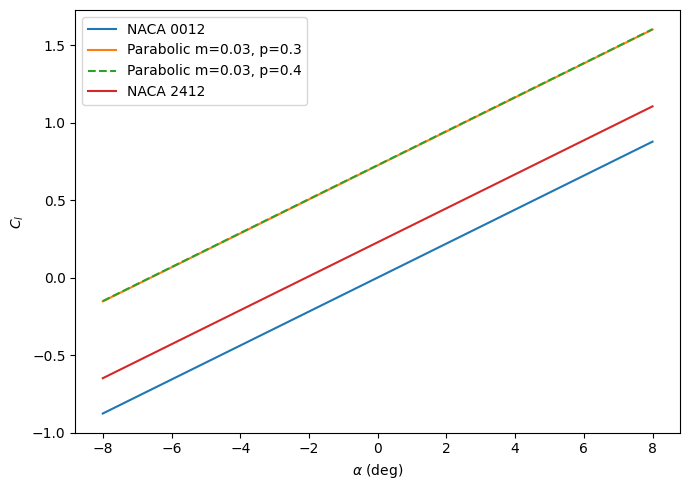

In [5]:
alpha_deg = np.linspace(-8, 8, 200)
alpha = np.deg2rad(alpha_deg)

Cl_0012 = 2*np.pi*alpha
Cl_m003_p03 = 2*np.pi*(alpha + 0.1152)
Cl_m003_p04 = 2*np.pi*(alpha + 0.1155)
Cl_2412 = 2*np.pi*(alpha + 0.03625)

plt.figure(figsize=(7,5))
plt.plot(alpha_deg, Cl_0012, label="NACA 0012")
plt.plot(alpha_deg, Cl_m003_p03, label="Parabolic m=0.03, p=0.3")
plt.plot(alpha_deg, Cl_m003_p04, label="Parabolic m=0.03, p=0.4",linestyle="--")
plt.plot(alpha_deg, Cl_2412, label="NACA 2412")
plt.xlabel(r"$\alpha$ (deg)")
plt.ylabel(r"$C_l$")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

def diff(x):
    return x[1:] - x[:-1]

def vortex_panel_CL(coords, alpha_deg):
    x = coords[:,0]
    y = coords[:,1]
    n = len(x) - 1

    alpha = np.deg2rad(alpha_deg)

    x_c = 0.5 * (x[:-1] + x[1:])
    y_c = 0.5 * (y[:-1] + y[1:])

    dx = diff(x)
    dy = diff(y)
    S = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)

    Cn1 = np.zeros((n, n))
    Cn2 = np.zeros((n, n))
    Ct1 = np.zeros((n, n))
    Ct2 = np.zeros((n, n))

    A_n = np.zeros((n+1, n+1))
    A_t = np.zeros((n+1, n+1))
    RHS = np.zeros((n+1, 1))

    for i in range(n):
        for j in range(n):
            if j != i:
                Xj = x[j]
                Yj = y[j]

                A = -(x_c[i] - Xj) * np.cos(theta[j]) - (y_c[i] - Yj) * np.sin(theta[j])
                B = (x_c[i] - Xj)**2 + (y_c[i] - Yj)**2
                C = np.sin(theta[i] - theta[j])
                D = np.cos(theta[i] - theta[j])
                E = (x_c[i] - Xj) * np.sin(theta[j]) - (y_c[i] - Yj) * np.cos(theta[j])
                F = np.log(1 + (S[j]**2 + 2*A*S[j]) / B)
                G = np.arctan2(E*S[j], B + A*S[j])
                P = (x_c[i] - Xj) * np.sin(theta[i] - 2*theta[j]) + (y_c[i] - Yj) * np.cos(theta[i] - 2*theta[j])
                Q = (x_c[i] - Xj) * np.cos(theta[i] - 2*theta[j]) - (y_c[i] - Yj) * np.sin(theta[i] - 2*theta[j])

                Cn2[i,j] = D + 0.5 * Q * F / S[j] - (A*C + D*E) * G / S[j]
                Cn1[i,j] = 0.5*D*F + C*G - Cn2[i,j]
                Ct2[i,j] = C + 0.5 * P * F / S[j] + (A*D - C*E) * G / S[j]
                Ct1[i,j] = 0.5*C*F - D*G - Ct2[i,j]

            else:
                Cn1[i,j] = -1.0
                Cn2[i,j] = 1.0
                Ct1[i,j] = 0.5 * np.pi
                Ct2[i,j] = 0.5 * np.pi

            if j == 0:
                A_n[i,j] = Cn1[i,j]
                A_t[i,j] = Ct1[i,j]
            else:
                A_n[i,j] = Cn1[i,j] + Cn2[i,j-1]
                A_t[i,j] = Ct1[i,j] + Ct2[i,j-1]

        A_n[i, n] = Cn2[i, n-1]
        A_t[i, n] = Ct2[i, n-1]
        RHS[i,0] = np.sin(theta[i] - alpha)

    A_n[n,0] = 1.0
    A_n[n,n] = 1.0

    Gamma = la.solve(A_n, RHS)

    Vtan = np.cos(theta - alpha).reshape(-1,1) + A_t[:n,:] @ Gamma
    Cp = 1 - Vtan**2

    gamma_p = 0.5 * (Gamma[:-1,0] + Gamma[1:,0])
    Gamma_tot = np.sum(gamma_p * S)

    c = np.max(x) - np.min(x)
    CL = 2*np.pi * Gamma_tot / c

    return CL, Cp, x_c, n


In [7]:
coords_base = np.loadtxt("coords.csv", delimiter=",")
CL0, Cp0, x_c0, N0 = vortex_panel_CL(coords_base, alpha_deg=0.0)
print("Panels:", N0)
print("CL(0 deg) =", CL0)

Panels: 34
CL(0 deg) = 0.14488370444332757


step= 3, panels= 12, CL=0.3469
step= 2, panels= 17, CL=0.4036
step= 1, panels= 34, CL=0.4074


/tmp/ipykernel_188/300185606.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


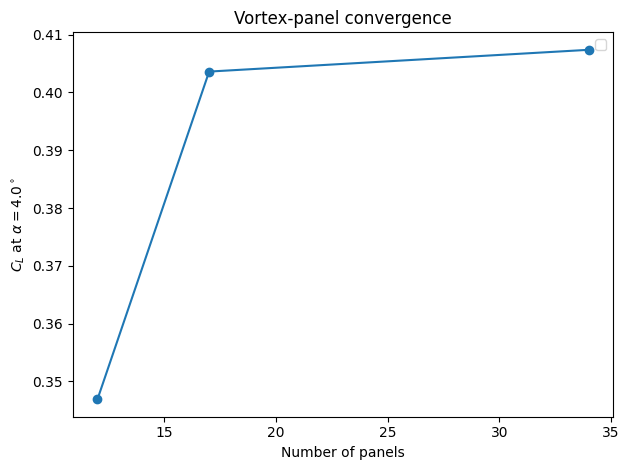

In [8]:
coords_base = np.loadtxt("coords.csv", delimiter=",")

def make_subsampled_coords(coords, step):
    out = coords[::step].copy()
    if not np.allclose(out[-1], coords[-1]):
        out = np.vstack([out, coords[-1]])
    return out

alpha_conv = 4.0
steps = [3, 2, 1]

num_panels_list = []
CL_list = []

for s in steps:
    sub = make_subsampled_coords(coords_base, s)
    CL_s, _, _, N_s = vortex_panel_CL(sub, alpha_conv)
    num_panels_list.append(N_s)
    CL_list.append(CL_s)
    print(f"step={s:2d}, panels={N_s:3d}, CL={CL_s:.4f}")

plt.figure()
plt.plot(num_panels_list, CL_list, marker="o")
plt.xlabel("Number of panels")
plt.ylabel(r"$C_L$ at $\alpha = %.1f^\circ$" % alpha_conv)
plt.title("Vortex-panel convergence")
plt.legend()
plt.tight_layout()
plt.show()

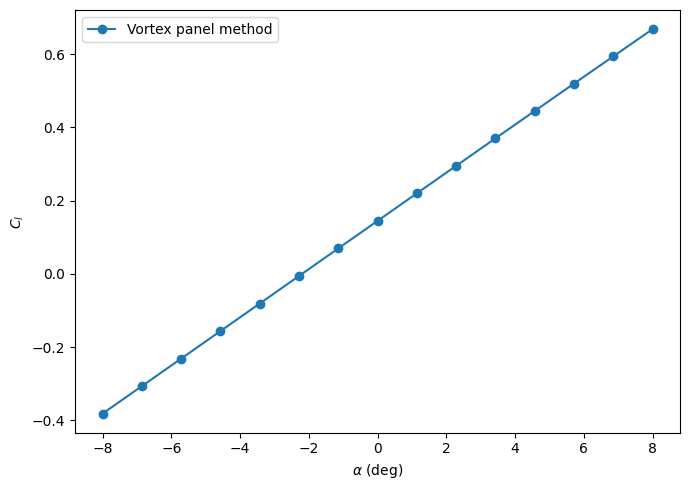

Approx. dCL/dα = 0.0656 per degree
Zero-lift angle α_L=0 ≈ -2.200 deg


In [10]:
alphas = np.linspace(-8, 8, 15)
CLs = []

for a in alphas:
    CL_val, _, _, _ = vortex_panel_CL(coords_base, a)
    CLs.append(CL_val)

CLs = np.array(CLs)

plt.figure(figsize=(7,5))
plt.plot(alphas, CLs, marker='o', label="Vortex panel method")
plt.xlabel(r"$\alpha$ (deg)")
plt.ylabel(r"$C_l$")
plt.legend()
plt.tight_layout()
plt.show()

slope = (CLs[-1] - CLs[0]) / (alphas[-1] - alphas[0])
print(f"Approx. dCL/dα = {slope:.4f} per degree")

coef = np.polyfit(alphas, CLs, 1)
alpha_L0 = -coef[1] / coef[0]
print(f"Zero-lift angle α_L=0 ≈ {alpha_L0:.3f} deg")
